编解码器结构是一种自监督学习，通过对比原图和结果图差别来训练。

1. 图片生成：将图片学到潜空间中，潜空间中必定有一些向量是图片不能完全对应的，这就可以产生新的结果。

2. 自编码器问题是容易过拟合，这就提出了VAE这一变体。通过加噪，是的每张图片对应潜空间的范围，而不再是一个点，增强泛化能力。模型引入：L1最小化重构损失（类似AE，引入噪声）；和L2。

输入：噪声+t； 输出：清晰图像
训练：添加噪声，模型通过大量的真实图像及其噪声版本进行训练，从而能预测噪声。
    随机加入噪声，越往后加的越大，可以一步到位。
生成：通过提供一个含有噪声的起始图像和一些指导条件(如文本描述)来预测噪声。
对比VAE：DDPM的加噪过程是固定的，减少学习压力。

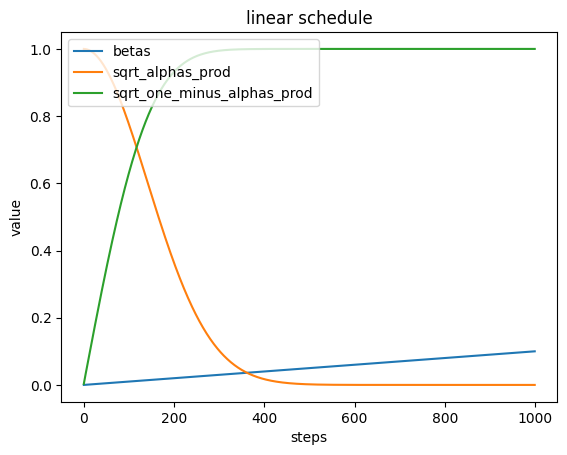

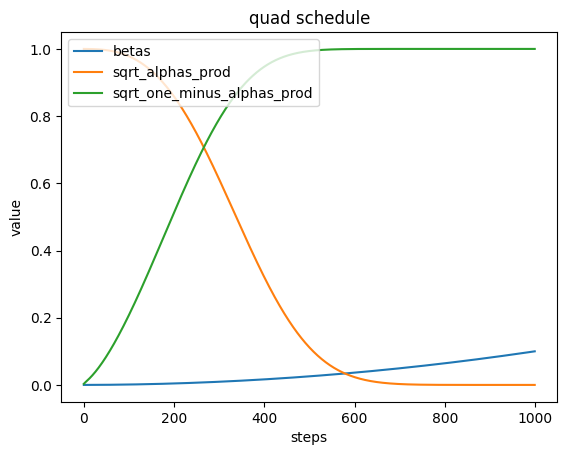

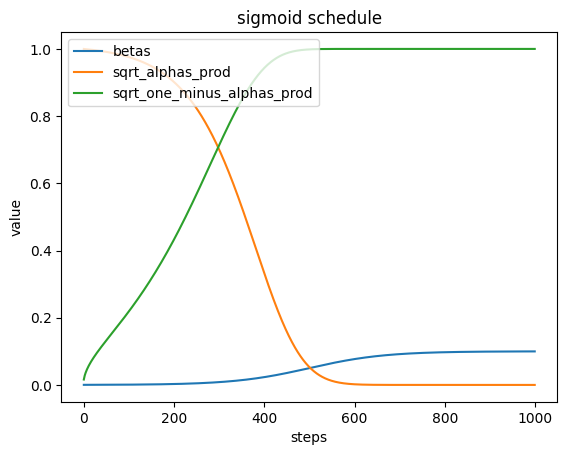

In [5]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 生成beta参数的调度表
# schedule: 调度类型（'linear', 'quad', 'sigmoid'）
# n_timesteps: 总的时间步数
# start: beta的起始值
# end: beta的结束值
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

# 从输入张量中提取特定时间步的值
# input: 输入张量
# t: 时间步张量
# x: 用于获取形状的参考张量
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

# 绘制不同调度类型的beta参数和相关参数随时间步的变化曲线
# n_steps: 总的时间步数
# schedule: 调度类型
def plot_schedule(n_steps,schedule):
    plt.plot(list(range(n_steps)),betas.numpy(),label='betas')
    plt.plot(list(range(n_steps)),torch.sqrt(alphas_prod).numpy(),label='sqrt_alphas_prod')
    plt.plot(list(range(n_steps)),torch.sqrt(1-alphas_prod).numpy(),label='sqrt_one_minus_alphas_prod')
    plt.legend(['betas','sqrt_alphas_prod','sqrt_one_minus_alphas_prod'],loc = 'upper left')
    plt.xlabel('steps')
    plt.ylabel('value')
    plt.title('{} schedule'.format(schedule))
    plt.show()

# 设置时间步数
n_steps = 1000

# 线性调度
schedule = 'linear'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)

# 二次方调度
schedule = 'quad'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)

# Sigmoid调度
schedule = 'sigmoid'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)


In [4]:
# 前向扩散
import torch

def noise_estimation_loss(model, x_0, n_steps):
    batch_size = x_0.shape[0] # 提取输入样本的批次维度[B, C, H, W]
    # 构造对称时间步（乱序，1，2，3；n-1-1,n-2-1,n-3-1）
    # 随机采样部分: tensor([234, 567, 890, 123, 456])- 234
    # 对称构造部分: tensor([765, 432, 109, 876, 543])- 765=1000-234-1
    # 最终时间步: tensor([234, 567, 890, 123, 456, 765, 432, 109])
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    # [t, n_steps - t - 1]两个向量拼接
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # a 形状会被调整为 [B, 1, 1, 1]
    a = extract(alphas_bar_sqrt, t, x_0) # 按时间步 t，从 alphas_bar_sqrt 中取对应值，适配 x_0 维度
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0) # 前向扩散的随机噪声，形状：与 x_0 相同，即 [B, C, H, W]
    x = x_0 * a + e * am1 # 计算扩散后的样本 xt，形状与 x_0 相同
    output = model(x, t) #模型输入含噪样本xt和时间步 t，输出预测噪声εθ
    return (e - output).square().mean() # 训练目标是让模型预测的噪声εθ逼近真实噪声ε，用均方误差（MSE）


def extract(input, t, x):
    shape = x.shape
    # 从 input 中根据 t 索引提取对应的值，[T]-> [B]（dim=0：沿着哪个维度进行索引）、
    # input 形状 [D0, D1, ..., Dn]
    out = torch.gather(input, 0, t.to(input.device))
    # 将形状为 [B] 的时间步系数张量，转换为 [B, 1, 1, ..., 1] 的多维张量，以便与图像张量（通常为 4 维 [B,C,H,W]）进行广播运算。
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [ ]:
# 单步反向去噪
def p_sample(model, x, t, alphas):
    # 执行 DDPM 反向过程的单步去噪（从xt采样 x_{t-1}）
    t = torch.tensor([t]) # 确保 t 是张量，形状 [1]
    eps_theta = model(x, t)
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    z = torch.randn_like(x) # 防止模式崩溃(模型找到错误规律并疯狂深入)，增加多样性
    sigma_t = extract(betas, t, x).sqrt() # betas是固定的预定义参数
    sample = mean + sigma_t * z # 增加多样性
    return sample



In [ ]:
# 实现通过Diffusion模型生成瑞士卷
# https://www.diantouedu.cn/video?course_id=163&period_id=2010&video_id=204777802&course_type=5
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

def sample_batch(size, noise=1.0):
    # 生成瑞士卷数据集的样本并做简单处理。
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

def extract(input, t, x):
    # 从输入张量 input 中，按时间步张量 t 提取对应元素，并调整形状适配 x 的维度
    # （常用于 DDPM 中按时间步取系数，如 βt，αt 等）。
    shape = x.shape
    # 沿第 0 维，根据 t 的索引从 input 中取值，保证 t 和 input 设备一致（CPU/GPU）。
    out = torch.gather(input, 0, t.to(input.device))
    # 让提取结果能与 x 广播运算（如 x 是 [B, C, H, W]，则结果形状会调整为 [B, 1, 1, 1] 适配）。
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    # β 调度表生成函数
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

def visualize_swiss_roll():
    # 用于生成并可视化瑞士卷数据集的样本
    data = sample_batch(1000)
    plt.figure(figsize=(10, 7))
    plt.scatter(data[:, 0], data[:, 1], c='blue', marker='o', s=10, alpha=0.5)
    plt.title('Swiss Roll Data Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

visualize_swiss_roll()

In [ ]:
# Diffusion模型复现和源码解读：
# https://www.bilibili.com/list/watchlater/?spm_id_from=333.1007.view_later.pip&bvid=BV1AM41137AF&t=4389&oid=528295305



Transformer：https://zhuanlan.zhihu.com/p/338817680
    Decoder block 的第一个 Multi-Head Attention 采用了 Masked 操作，因为在翻译的过程中是顺序翻译的，即翻译完第 i 个单词，才可以翻译第 i+1 个单词。通过 Masked 操作可以防止第 i 个单词知道 i+1 个单词之后的信息。

Transformer详细解释和多头原理详解：
    https://www.bilibili.com/video/BV1xoJwzDESD/?spm_id_from=333.337.search-card.all.click&vd_source=f532db78cbfe857f8de18d43caa41a3e
    <img src="./Transformer-01.png">

Diffusion图像生成注意的点：

用Diffusion：
思路1. 描述准确度
    - 可控性核心可能在描述准确度上，描述是否能达到核心。分为“语义理解”和“生成的稳定性”。
    - 一是语义工程；二是注意力门控，静态掩码生成效果不好。更多针对第一步CLIP做科研。
    - CLIP中语义冲突，文本和草图不同，生成结果偏离预期，思路是加一个冲突感知器，计算文本和草图边缘相似度，不一致则重新生成。这样可以进行局部加权（生成到一半，发现问题，返回重新加权掩码）。是否可以在已有attention调节模型前加上Controlnet，使得权重调整变成动态的。
    - 

思路2. deepseek思考过程，为什么会有多轮，这个变化的思路。
参考LSTM，时间序列门控的设计思路。

论文参考：多轮、门控、循环相关论文；控制生成过程，控制器如何设计，如何接入。区域掩码。SD3的内容。


思路3. 模型生成过程的加速
混合专家，最后整合。


Unet